# Problem Set 2022/23 - Simon Hilding-Nørkjær (xsj415)


### Pre-loading packages and functions: 

In [276]:
import numpy as np                                     
from numpy.linalg import matrix_power                  
import matplotlib.pyplot as plt                                                        
from iminuit import Minuit                            
import sys                                            
from scipy import stats
from scipy.integrate import quad
import sympy as sp
from sympy import integrate
import pandas as pd

plt.style.use('classic')

sys.path.append('../External_Functions')
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax   

sys.path.append('../MyExternalFunctions')
from MyExternalFunctions import Errorpropagation

In [205]:
eq, func , func_err, contrib = Errorpropagation('cos(x)**3+y**2', 'x y')

symbols = sp.symbols('x y sigma_x sigma_y')
sigmax = sp.lambdify(symbols,contrib[0])
sigmay = sp.lambdify(symbols,contrib[1])

print(sigmax(1,1,0.1,0.1))
print(contrib[0])

func_err(2,3,0.1,0.1)
eq

0.005430853458364827
9*sigma_x**2*sin(x)**2*cos(x)**4


sqrt(9*sigma_x**2*sin(x)**2*cos(x)**4 + 4*sigma_y**2*y**2)

## I - Distributions and probabilities:

### 1.1) Your friend tells you, that a bag contains 3 white, 6 black, and 7 grey marbles.

#### 1.1.1) If you take two random marbles without putting them back, what is the probability that at least one of them is white?

In [10]:
n_white , n_black , n_grey = 3 , 6 , 7
N = n_white + n_black + n_grey

#first draw
p_white = n_white/N
p_other = 1-p_white

#second draw
p_other_given_other = (n_black+n_grey-1)/(N-1)
p_atleast1white = 1 - p_other*p_other_given_other

print('Probability of at least one white marble =',p_atleast1white)  

Probability of at least one white marble = 0.35


#### 1.1.2) If you pick a marble, record its color, and then put it back 25 times independently, what is the probability of getting exactly 18 grey marbles? At least 18 grey marbles?

In [11]:
p_grey = n_grey/N
P_18grey_of_25 = stats.binom.pmf(18,25,p_grey)
P_atleast_18grey_of_25 = stats.binom.sf(17,25,p_grey)
print('Probability of 18 grey marbles out of 25 trials =',P_18grey_of_25)
print('Probability of at least 18 grey marbles out of 25 trials =',P_atleast_18grey_of_25)

Probability of 18 grey marbles out of 25 trials = 0.002953499094615582
Probability of at least 18 grey marbles out of 25 trials = 0.004039599792444158


#### 1.1.3) If you got 18 grey marbles out of 25 picks, would you trust your friend’s information?

In [12]:

# expected number of grey marbles
Expected_grey = 25*p_grey
# binomial standard deviation of grey marbles
sigma_grey = np.sqrt(25*p_grey*(1-p_grey))    
# z-score
z = (18-Expected_grey)/sigma_grey
# p-value
p = stats.norm.sf(z)


print('z-score =',z)
print('p-value =',p)
print('Conclusion: I would not trust the information as the p-value based on the z-score show is really low.')

z-score = 2.8473323633361787
p-value = 0.0022043653491208926
Conclusion: I would not trust the information as the p-value based on the z-score show is really low.


### 1.2) 
The lifetime L of a certain component is exponentially distributed: L(t) = 1/τ exp(−t/τ ).
If there is a 4% chance of this component lasting more than 500 hours, what is the value of τ ?

In [13]:
#solving the intgral of L(t) = 1/τ exp(−t/τ ) from 0 to 500 using sympy 

t, tau = sp.symbols('t tau', real=True)
L = 1/tau*sp.exp(-t/tau)
P_L500 = integrate(L,(t,500,sp.oo),conds='none')
Tau = sp.solve(P_L500-0.04,tau)   #solving for tau and because the integral is from 500 to infinity

print(r'The lifetime of the particle is {:.2f}, hours'.format(Tau[0]))

The lifetime of the particle is 155.33, hours


### 1.3) A radio telescope detects 241089 signals/day, based on a 9 week observation campaign.

#### 1.3.1) One hour, it receives 9487 signals. What is the chance of observing exactly this number?

In [14]:
detection_rate = 241089       #counts per day 
signal = 9487                 #signal in one hour

#probability of detecting the signal in one hour
P_signal = stats.poisson.pmf(signal,detection_rate/24)
print('Probability of detecting the signal in one hour: ',P_signal.round(12))


Probability of detecting the signal in one hour:  5.55e-10


#### 1.3.2) Is this observation extraordinary, based on an estimate of its general probability?

In [15]:
#expected number of signal in one hour
Expected_signal = detection_rate/24

#Poissonian standard deviation of signal in one hour
sigma_signal = np.sqrt(detection_rate/24)

#z-score
z = (abs(signal-Expected_signal))/sigma_signal

#p-value
p = stats.norm.sf(z)

print('z-score =',z)
print('p-value =',p)
print('Conclusion: Very unlikely observation based on p-value and z-score.')

z-score = 5.571124816057189
p-value = 1.2654995762494655e-08
Conclusion: Very unlikely observation based on p-value and z-score.


### 1.4 )  Shooting with a bow, you have 3% chance of hitting a certain target

#### 1.4.1) What distribution is the number of hits going to follow, given N shots?

In [16]:
#Binomial distribution with p=0.03 give N shots

#### 1.4.2) What is the probability that the first hit will come after 20 shots?

In [17]:
#probability of getting first hit within 20 shots
P_firsthit = (1-p)**20 * p
print(f'Probability of getting first hit after 20 shots given N shots: {P_firsthit:.3f}')

Probability of getting first hit after 20 shots given N shots: 0.000


#### 1.4.3) What is the probability that it will take more than 4000 shots to hit the target 100 times?

In [18]:
#probability of it taking more than 4000 shots to hit 100 times 
P_4000shots = stats.binom.sf(99,4000,p)
print('Probability of it taking more than 4000 shots to hit 100 times: ',P_4000shots.round(3))

Probability of it taking more than 4000 shots to hit 100 times:  0.0


## II - Error Propagation

### 2.1)  Let x = 1.92 ± 0.39 and y = 3.1 ± 1.3, and let z1 = y/x, and z2 = cos(x) · x/y

In [19]:
X =  1.92 
Xerr = 0.39
Y = 3.1 
Yerr = 0.3

def z1(x,y):
    return y/x 

def z2(x,y):
    return np.cos(x)*y/x

#### 2.1.1)  What are the uncertainties of z1 and z2, if x and y are uncorrelated?

#### 2.1.2) If x and y were highly correlated (ρxy = 0.95), what would be the uncertainty on z1?

In [20]:
# '
# class ErrorPropagation:
#     def __init__(self, func, variables, errors):
#         self.func = func
#         self.variables = variables
#         self.errors = errors

#         # Initialize symbols for the variables
#         self.symbols = sp.symbols([f'x{i}' for i in range(len(variables))])

#         # Define the function using the sympy symbols
#         self.symbolic_func = func(*self.symbols)

#         # Calculate the partial derivatives of the function with respect to each variable
#         self.partial_derivatives = [self.symbolic_func.diff(var) for var in self.symbols]

#     def calculate_error(self):
#         # Substitute the values of the variables into the partial derivatives
#         partial_derivatives = [deriv.subs(zip(self.symbols, self.variables)) for deriv in self.partial_derivatives]

#         # Calculate the error using the formula for error propagation
#         error = 0
#         for i in range(len(self.variables)):
#             error += (partial_derivatives[i] * self.errors[i])**2
#         return sp.sqrt(error)

#     def get_symbolic_formula(self):
#         # Substitute the symbols back into the partial derivatives
#         partial_derivatives = [deriv.subs(zip(self.symbols, self.symbols)) for deriv in self.partial_derivatives]

#         # Calculate the symbolic formula for the propagated error
#         error = 0
#         for i in range(len(self.variables)):
#             error += (partial_derivatives[i] * f'error_{i}')**2
#         return sp.sqrt(error)

# # Example usage
# def my_func(x, y, z):
#     return x**2 + y**2 + z**2

# ep = ErrorPropagation(my_func, [1, 2, 3], [0.1, 0.2, 0.3])
# error = ep.calculate_error()
# print(error)  # Outputs: 0.9428090415820634

# symbolic_formula = ep.get_symbolic_formula()
# print(symbolic_formula)  # Outputs: sqrt((2*x0*error_0)**2 + (2*x1*error_1)**2 + (2*x2*error_2)**2)


#### 2.1.3) Which of the (uncorrelated) variables x and y contributes most to the uncertainty on z2?

### 2.2) Five patients were given a drug to test if they slept longer (in hours). 
##### Their results were:+3.7, −1.2, −0.2, +0.7, +0.8. A Placebo group got the results: +1.5, −1.0, −0.7, +0.5, +0.1

In [21]:
drug_group = np.array([3.7, -1.2, -0.2, 0.7, 0.8])
placebo_group = np.array([1.5, -1.0, -0.7, 0.5, 0.1])

#### 2.2.1) Estimate the mean, standard deviation, and the uncertainty on the mean for drug group

In [22]:
#mean , std and error on the mean of drug group
mean_drug = np.mean(drug_group)
std_drug = np.std(drug_group, ddof=1)
err_drug = std_drug/np.sqrt(len(drug_group))

#mean , std and error on the mean of placebo group
mean_placebo = np.mean(placebo_group)
std_placebo = np.std(placebo_group, ddof=1)
err_placebo = std_placebo/np.sqrt(len(placebo_group))


# print the results
print('Drug group: Mean = {:.2f} +/- {:.2f}, STD of distribution = {:.2f}'.format(mean_drug,err_drug,std_drug))
print('Placebo group: Mean = {:.2f} +/- {:.2f}, STD of distribution = {:.2f}'.format(mean_placebo,err_placebo,std_placebo))

Drug group: Mean = 0.76 +/- 0.82, STD of distribution = 1.83
Placebo group: Mean = 0.08 +/- 0.45, STD of distribution = 1.00


#### 2.2.2) What is the probability that the drug group slept longer than the placebo group?

As the means and std's for the two samples are estimated we have to use the students t test in order to test the null hypothesis that the true sample means are equal. 

In [275]:
#calculate the student t-test for the means of two independent samples of scores
t, p_ttest = stats.ttest_ind(drug_group, placebo_group, equal_var=False, alternative='greater')

print(f't-statistic = {t:.2f}')
print(f'p-value = {p_ttest:.2f}')

t-statistic = 0.73
p-value = 0.25


## III - Simulation / Monte Carlo:

### 3.1) Assume $f(x) = Cx^asin(πx)$ for x ∈ [0, 1] and a = 3 is a theoretical distribution.

#### 3.1.1) By what method(s) would you generate random numbers according to f (x)?

As the function f(x) is not invertable we cannot use the Inverse Transform method. Instead I will use the acceptance-rejection method for generation radom numbers according to f(x).


#### 3.1.2) Determine (possibly numerically) the value of C for f (x) to be normalised.


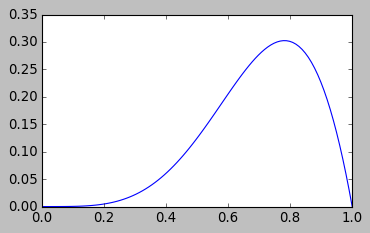

In [24]:
xmin, xmax = 0, 1

def f(x,a,C):
    return x**a*np.sin(np.pi*x) * C

xAxis = np.linspace(xmin,xmax,100)
fig,ax = plt.subplots(1,1,figsize=(5,3))
ax.plot(xAxis,f(xAxis,a=3,C=1))

In [282]:
#Choosing range of y values between 0 and 0.35 according to the plot
r = np.random
r.seed(1234)

ymin, ymax = 0, 0.35

N_try = 0
N_accepted = 20000
x_accepted = []

while len(x_accepted) < N_accepted:
    x = r.uniform(xmin,xmax)
    y = r.uniform(ymin,ymax)
    if y < f(x,a=3,C=1):
        x_accepted.append(x)
    N_try += 1

print('Number of tries: ',N_try)


Number of tries:  55992


In [283]:
# Efficiency
eff = N_accepted / N_try 
eff_error = np.sqrt(eff * (1-eff) / N_try)        # binomial error

# Integral
integral =  eff * (xmax-xmin) * (ymax-ymin)
eintegral = eff_error * (xmax-xmin) * (ymax-ymin)  

# Normalization is then 
norm = 1 / integral
enorm = eintegral / integral**2

print(r'Efficiency = {:.3f} +/- {:.3f}'.format(eff,eff_error))
print(r'Integral = {:.4f} +/- {:.4f}'.format(integral,eintegral))
print(r'Normalization = {:.3f} +/- {:.3f}'.format(norm,enorm))

Efficiency = 0.357 +/- 0.002
Integral = 0.1250 +/- 0.0007
Normalization = 7.999 +/- 0.045


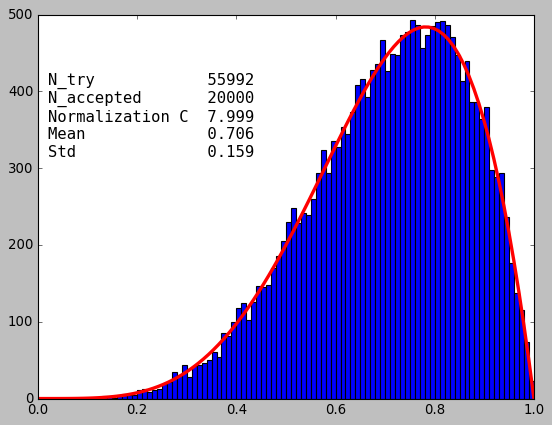

In [284]:
Nbins= 100
binwidth  = (xmax-xmin)/Nbins

xAxis = np.linspace(xmin,xmax,100)
y = f(xAxis,a=3,C=1) * norm  * N_accepted * binwidth


#plot the histogram of the generated numbers with the function f(x)

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(xAxis,y,c='C2',lw=3)
ax.hist(x_accepted,bins=int(Nbins),range=(xmin,xmax))


# Define the figure text
d2 = {'N_try': N_try,
      'N_accepted': N_accepted,
      'Normalization C': norm,
      'Mean': np.mean(x_accepted),
      'Std': np.std(x_accepted,ddof=1),
    }

# Add figure text
text2 = nice_string_output(d2, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.85, text2, ax, fontsize=14)

#### 3.1.3) Fit a histogram with values from f (x) and determine how many measurements (i.e. values of x) you need in an experiment to determine the value of a with 1% precision.

In [285]:
# test how big N should be to determine a with 1% precision

N_test = np.arange(100, N_accepted, 100, dtype=int)
a_values = []
a_errors = []
precisions = []
precision_errors = []

for i in N_test:
    counts, bin_edges = np.histogram(x_accepted[:i], bins=Nbins, range=(xmin,xmax), density=False)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    #remove empty bins 
    mask = counts > 0
    counts = counts[mask]
    bin_centers = bin_centers[mask]
    counts_errors = np.sqrt(counts)

    #fit the function
    chi2 = Chi2Regression(f, bin_centers, counts, counts_errors)
    minuit = Minuit(chi2, a=0, C=0)
    minuit.migrad()
    a, C = minuit.values
    a_err, C_err = minuit.errors

    precision = a_err / a
    precision_err = a_err**2 / a**2
    
    a_values.append(a)
    a_errors.append(a_err)
    precisions.append(precision)
    precision_errors.append(precision_err)



In [286]:
#fit the precision
def precision_of_N(x,p1,p2):
    return p1*x**p2

chi2 = Chi2Regression(precision_of_N, N_test, precisions, precision_errors)
minuit = Minuit(chi2, p1=1, p2=-0.5)
minuit.migrad()
p1, p2 = minuit.values
p1_err, p2_err = minuit.errors
minuit

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 165.5                      │              Nfcn = 82               │
│ EDM = 6.92e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ p1   │   1.311   │   0.023   │            │            │         │         │       │
│ 1 │ p2   │  -0.5049  │  0.0018   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────┐
│    │        p1        p2 │
├────┼─────────────────────┤
│ p1 │  0.000523 -4.23e-05 │
│ p2 │ -4.23e-05  3.43e-06 │
└────┴─────────────────────┘

C:\Users\simon\AppData\Local\Temp\ipykernel_14304\151751878.py:3: RuntimeWarning: invalid value encountered in power
  return p1*x**p2


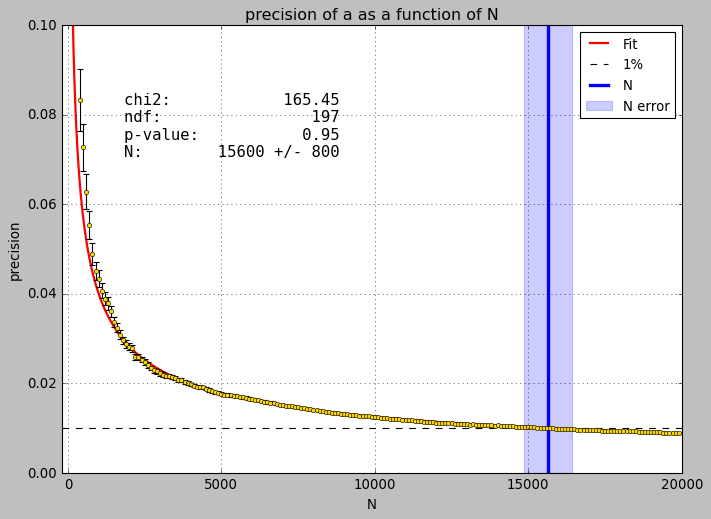

In [287]:
#solve the equation for N to get the precision of 1%
x , p1_par, p2_par = sp.symbols('x p1 p2')
eq1 = sp.solve(p1_par * x**p2_par-0.01,x)
eq1 = eq1[0]

eq, func , func_err, contrib = Errorpropagation(str(eq1), 'p1 p2')

N_final = func(p1,p2)
N_final_err = func_err(p1,p2,p1_err,p2_err)



xAxis = np.linspace(-200, N_accepted,1000)
fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(xAxis,precision_of_N(xAxis,p1,p2),c='C2',lw=2)
ax.errorbar(N_test,precisions,yerr=precision_errors,ecolor='k',mec='k',mfc='gold',fmt='.',ms=8,capsize=3,capthick=1)
ax.axhline(0.01,ls='--',c='k')
ax.axvline(N_final,c='b',lw=3)
ax.axvspan(N_final-N_final_err, N_final+N_final_err, alpha=0.2, color='b')
ax.grid(), ax.set(xlim=(-200,N_accepted), ylim= (0,0.1),xlabel='N',ylabel='precision',title='precision of a as a function of N')
ax.legend(['Fit','1%','N','N error'],fontsize=12)

#calculate the p-value of the fit 
chi2 = minuit.fval
ndf = len(N_test) - minuit.nfit
p_value = stats.chi2.sf(chi2, ndf)


# Define the figure text
N_final = int(np.round(N_final,-2))
N_final_err = int(np.round(N_final_err,-2))
d2 = {'chi2:': chi2,
    'ndf:': ndf,
    'p-value:': p_value,
    'N:': [N_final,N_final_err],

    }

# Add figure text
text2 = nice_string_output(d2, extra_spacing=2, decimals=2)
add_text_to_ax(0.1, 0.85, text2, ax, fontsize=14)

## IV – Statistical tests:


#### 4.1 (12 points) You measure the grip strength (G in Newton N ) in the dominant and non-dominanthands (based on writting) of 84 persons, to determine if there is a difference. The data is sum-marised in the file www.nbi.dk/∼petersen/data GripStrength.txt.


In [278]:
dataframe = pd.read_csv('data_GripStrength.csv', header=0, index_col=None)
domhand, dom_grip, ndom_grip = dataframe.values.T
dataframe

,DominantHand,DominantGrip(N),NonDominantGrip(N)
0,1.0,293.24,241.50
1,1.0,547.39,552.01
2,0.0,578.85,495.98
3,1.0,342.30,342.18
4,1.0,337.79,347.14
...,...,...,...
79,1.0,335.67,305.39
80,1.0,362.91,336.60
81,1.0,659.39,623.32
82,1.0,292.84,254.46


##### 4.1.1) From this sample, What fraction of persons are right (dominant hand = 1) handed?

In [296]:
frac_right_handed = np.sum(domhand)/len(domhand)
frac_right_handed_err = np.sqrt(frac_right_handed*(1-frac_right_handed)/len(domhand))       # binomial error 

frac_left_handed = 1-frac_right_handed
frac_left_handed_err = np.sqrt(frac_left_handed*(1-frac_left_handed)/len(domhand))          

print('Fraction of right handed people: {:.2f} +- {:.2f}'.format(frac_right_handed,frac_right_handed_err))
print('Fraction of left handed people: {:.2f} +- {:.2f}'.format(frac_left_handed,frac_left_handed_err))

Fraction of right handed people: 0.81 +- 0.04
Fraction of left handed people: 0.19 +- 0.04


##### 4.1.2) What is the mean and standard deviation of the dominant and non-dominant grip strengths?

In [294]:
dom_grip_mean = np.mean(dom_grip)
dom_grip_meanstd = np.std(dom_grip,ddof=1)/np.sqrt(len(dom_grip))
ndom_grip_mean = np.mean(ndom_grip)
ndom_grip_meanstd = np.std(ndom_grip,ddof=1)/np.sqrt(len(ndom_grip))

print('Mean grip strength of dominant hand: {:.2f} +- {:.2f}'.format(dom_grip_mean,dom_grip_meanstd))
print('Mean grip strength of non-dominant hand: {:.2f} +- {:.2f}'.format(ndom_grip_mean,ndom_grip_meanstd))


Mean grip strength of dominant hand: 444.93 +- 15.82
Mean grip strength of non-dominant hand: 418.48 +- 15.08


##### 4.1.3) Are the means of the two distributions compatible or different?

In [299]:
# the null hypothesis is that the distributions means are equal. It is rejected if p-value is smaller than 0.05 significance level

# student t-test
t, p = stats.ttest_ind(dom_grip, ndom_grip, equal_var=True)
print('t-statistic: {:.2f}'.format(t))
print('p-value: {:.2f}'.format(p))

# the null hypothesis cannot be rejected at 95% confidence level


t-statistic: 1.21
p-value: 0.23


##### 4.1.4) What is the mean and standard deviation of the individual differences in grip strengths?

Mean difference in grip strength: 26.45 +- 3.19


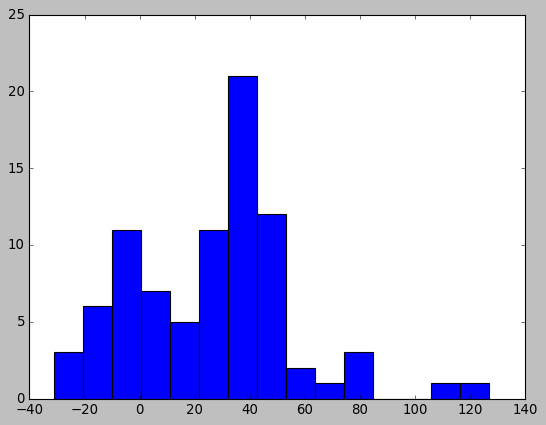

In [306]:
diff_grip = dom_grip - ndom_grip
diff_grip_mean = np.mean(diff_grip)
diff_grip_meanstd = np.std(diff_grip,ddof=1)/np.sqrt(len(diff_grip))

print('Mean difference in grip strength: {:.2f} +- {:.2f}'.format(diff_grip_mean,diff_grip_meanstd))

Nbins = 15
plt.hist(diff_grip,bins=Nbins, range=(min(diff_grip),max(diff_grip)));

##### 4.1.5) Is there a statistically significant difference in grip strengths between hands?

In [308]:
 #Is there a statistically significant difference in grip strengths between hands?

# the null hypothesis is that the dominant hand has a higher grip strength than the non-dominant hand. 

